# <font color = 'black'>*Telecom Churn Analysis*<font>
-------------------------------------------------------------------------------------------------------------------
# <font color='blue'>**Business Understanding**<font>

- **<font color='lightcoral'>Problem Statement<font>**:
    - Retaining high profitable customers by predicting which customers are at high risk of churn.As approximately 80% of revenue comes from the top 20% customers (called high-value customers).
    - Identify the main risk indicators of churn.


- **<font color='lightcoral'>Business Scope<font>**: 
    - This project is based on the Indian and Southeast Asian market.Also, prepaid is the most common model in India and southeast Asia, while postpaid is more common in Europe in North America.

# <font color='blue'>**Data Understanding**<font>

- **<font color='lightcoral'>Dataset Details<font>**:
    - Customer-level data of a leading telecom firm based on Indian and Southeast Asian market for Prepaid model.
    - The dataset contains information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 

- **<font color='lightcoral'>Business Constraints<font>**: 
    - usage-based definition to define churn model.
    - The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months.

- **<font color='lightcoral'>Data Dictionary<font>**:
    - Data dictionary helps us understand type of each column and its description
    - Data type of each attribute can be estimated from this information
    - Importance of each column towards churn with business understanding

In [1]:
# Import required libraries

import xlrd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


%matplotlib inline

pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 300)

In [2]:
# Upload data dictionary
data_dictionary = pd.read_excel('Data+Dictionary-+Telecom+Churn+Case+Study.xlsx')
data_dictionary

,Acronyms,Descriptions
0,MOBILE_NUMBER,Customer phone number
1,CIRCLE_ID,Telecom circle area to which the customer belo...
2,LOC,Local calls - within same telecom circle
3,STD,STD calls - outside the calling circle
4,IC,Incoming calls
5,OG,Outgoing calls
6,T2T,"Operator T to T, i.e. within same operator (mo..."
7,T2M,Operator T to other operator mobile
8,T2O,Operator T to other operator fixed line
9,T2F,Operator T to fixed lines of T


# <font color='blue'>Data Preperation- Planned analysis</font>

    -1. Upload dataset and validate
    -2. Data investigation/ Data Cleaning
        - Column renaming
        - Data type conversion
        - Missing value treatment
    -3. Filter High-rated customers (HVC)
    -4. Churn labelling (Target definition)
    -5. Derive new features
    -6. Exploratory data analysis
        - Outlier treatment
        - Univariate analysis
        - Bivariate analysis
    -7. Handle class imbalance problem    
    -8. Model-1 : PCA based model    
    -9. Model-2: Interpretable model
    -10. Insights/ Recommendations    

### **<font color='lightcoral'>Step 1. Upload Data and validate  <font>**
    - Upload data into notebook with proper encoding.
    - Validate number of records and attributes.
    - Display head view to get a feel of data.

In [3]:
# Upload telecom churn dataset
churn_data = pd.read_csv('telecom_churn_data.csv', low_memory=False)
# Take a backup for reference
churn_data_copy = churn_data.copy()
print('Head view of churn data:')
print('~'*100)
print(churn_data.head())

Head view of churn data:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109            0.00            0.00            0.00   
1     7001865778        109            0.00            0.00            0.00   
2     7001625959        109            0.00            0.00            0.00   
3     7001204172        109            0.00            0.00            0.00   
4     7000142493        109            0.00            0.00            0.00   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31

In [4]:
# Data Validation if properly loaded everything
# Data information helps to understand the data types of variables
print('~'*100)
print(f'There are {churn_data.shape[0]} rows and {churn_data.shape[1]} columns in loaded dataset.')
print('~'*100)
print('Variable Information:')
print('~'*100)
print(churn_data.info(verbose = 1,null_counts=True))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
There are 99999 rows and 226 columns in loaded dataset.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Variable Information:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
mobile_number               99999 non-null int64
circle_id                   99999 non-null int64
loc_og_t2o_mou              98981 non-null float64
std_og_t2o_mou              98981 non-null float64
loc_ic_t2o_mou              98981 non-null float64
last_date_of_month_6        99999 non-null object
last_date_of_month_7        99398 non-null object
last_date_of_month_8        98899 non-null object
last_date_of_month_9        98340 non-null object
arpu_6                      99999 non-null float64
arpu_7 

### Step 1: Inference
    - Data uploaded successfully and validated based on records and columns
    - mobile number is unique key attribute.
    - Loaded dataframe has no duplicates
    - Monthly (6,7,8 & 9) KPI columns are close to 90% of provided data
    - There are some columns data type conversion needed.
    - It seems there are many records with missing values.

### <font color='lightcoral'>**Step 2: Data Investigation/ Cleaning**<font>
    - Column renaming
    - Data type conversion
    - Missing value treatment

In [5]:
# Column naming
pd.DataFrame(churn_data.columns)

,0
0,mobile_number
1,circle_id
2,loc_og_t2o_mou
3,std_og_t2o_mou
4,loc_ic_t2o_mou
5,last_date_of_month_6
6,last_date_of_month_7
7,last_date_of_month_8
8,last_date_of_month_9
9,arpu_6


#### Update column names to properly to maintain uniformity

In [6]:
# there are columns with month names : jun_vbc_3g, jul_vbc_3g, aug_vbc_3g, sep_vbc_3g

churn_data.rename(columns={'aug_vbc_3g':'vbc_3g_8',
                          'jul_vbc_3g':'vbc_3g_7',
                          'jun_vbc_3g':'vbc_3g_6',
                          'sep_vbc_3g':'vbc_3g_9'}, 
                 inplace=True)

#### Identify each column datatype with help of data decription file.
    - ID columns
    - Date columns
    - Boolean category columns
    - Revenue columns (Numeric)
    - Recharge type column (Numeric)

In [7]:
# There are date,numeric,id and catagorical columns with improper data types.

# id columns set
id_columns_set = ['mobile_number','circle_id']

# Filter date columns with 'date' in column names
date_columns_set = [col for col in churn_data.columns if 'date' in col]

# Data description file helps to identify boolean category columns
category_columns_set =  ['night_pck_user_6','night_pck_user_7','night_pck_user_8','night_pck_user_9','fb_user_6','fb_user_7','fb_user_8','fb_user_9']

# Revenue type columns
revenue_cols = [col for col in churn_data.columns if 'arpu' in col]

# Rest of the attrributes fall into numeric type of data
numeric_columns_set = [column for column in churn_data.columns if column not in id_columns_set + date_columns_set + category_columns_set]

#### Convert date columns

In [8]:
# convert to datetime
for col in date_columns_set:
    churn_data[col] = pd.to_datetime(churn_data[col])

In [9]:
print('Information of date column only')
print('~'*100)
pd.DataFrame(churn_data[date_columns_set].info())
print('Data description for date column only')
print('~'*100)
pd.DataFrame(churn_data[date_columns_set].describe())

Information of date column only
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 12 columns):
last_date_of_month_6        99999 non-null datetime64[ns]
last_date_of_month_7        99398 non-null datetime64[ns]
last_date_of_month_8        98899 non-null datetime64[ns]
last_date_of_month_9        98340 non-null datetime64[ns]
date_of_last_rech_6         98392 non-null datetime64[ns]
date_of_last_rech_7         98232 non-null datetime64[ns]
date_of_last_rech_8         96377 non-null datetime64[ns]
date_of_last_rech_9         95239 non-null datetime64[ns]
date_of_last_rech_data_6    25153 non-null datetime64[ns]
date_of_last_rech_data_7    25571 non-null datetime64[ns]
date_of_last_rech_data_8    26339 non-null datetime64[ns]
date_of_last_rech_data_9    25922 non-null datetime64[ns]
dtypes: datetime64[ns](12)
memory usage: 9.2 MB


""


Data description for date column only
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
count,99999,99398,98899,98340,98392,98232,96377,95239,25153,25571,26339,25922
unique,1,1,1,1,30,31,31,30,30,31,31,30
top,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-31 00:00:00,2014-09-30 00:00:00,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-31 00:00:00,2014-09-29 00:00:00,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-31 00:00:00,2014-09-29 00:00:00
freq,99999,99398,98899,98340,16960,17288,14706,22623,1888,1813,1998,2329
first,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-31 00:00:00,2014-09-30 00:00:00,2014-06-01 00:00:00,2014-07-01 00:00:00,2014-08-01 00:00:00,2014-09-01 00:00:00,2014-06-01 00:00:00,2014-07-01 00:00:00,2014-08-01 00:00:00,2014-09-01 00:00:00
last,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-31 00:00:00,2014-09-30 00:00:00,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-31 00:00:00,2014-09-30 00:00:00,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-31 00:00:00,2014-09-30 00:00:00


In [10]:
# Missing values for each column

def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print('~'*100)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        print('~'*100)
        return mis_val_table_ren_columns
print(missing_values_table(churn_data))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Your selected dataframe has 226 columns.
There are 166 columns that have missing values.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                          Missing Values  % of Total Values
count_rech_2g_6                    74846              74.80
max_rech_data_6                    74846              74.80
arpu_3g_6                          74846              74.80
av_rech_amt_data_6                 74846              74.80
count_rech_3g_6                    74846              74.80
night_pck_user_6                   74846              74.80
arpu_2g_6                          74846              74.80
fb_user_6                          74846              74.80
total_rech_data_6                  74846              74.80
date_of_last_rech_data_6           74846              74.80
count_rech_3g_7                    74428         

In [11]:
# some recharge columns have minimum value of 1 while some don't
recharge_cols = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9',
                 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9',
                 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9',
                 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
                 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9',
                 ]
print('Summary of Recharge data')
print('~'*100)
print(pd.DataFrame(churn_data[recharge_cols].describe()).transpose())
print('~'*100)
print('Summary of Revenue data')
print(pd.DataFrame(churn_data[revenue_cols].describe()).transpose())

#In the recharge variables where minumum value is 1/0.5, we can impute missing values with zeroes since it means customer didn't recharge their numbere that month.

Summary of Recharge data
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                      count   mean    std  min   25%    50%    75%     max
total_rech_data_6  25153.00   2.46   2.79 1.00  1.00   1.00   3.00   61.00
total_rech_data_7  25571.00   2.67   3.03 1.00  1.00   1.00   3.00   54.00
total_rech_data_8  26339.00   2.65   3.07 1.00  1.00   1.00   3.00   60.00
total_rech_data_9  25922.00   2.44   2.52 1.00  1.00   2.00   3.00   84.00
count_rech_2g_6    25153.00   1.86   2.57 0.00  1.00   1.00   2.00   42.00
count_rech_2g_7    25571.00   2.04   2.77 0.00  1.00   1.00   2.00   48.00
count_rech_2g_8    26339.00   2.02   2.72 0.00  1.00   1.00   2.00   44.00
count_rech_2g_9    25922.00   1.78   2.21 0.00  1.00   1.00   2.00   40.00
count_rech_3g_6    25153.00   0.60   1.27 0.00  0.00   0.00   1.00   29.00
count_rech_3g_7    25571.00   0.62   1.39 0.00  0.00   0.00   1.00   35.00
count_rech_3g_8    26339.00   0.64   1.42 0.00  0

#### We can observe below that, it is better to impute with zero for recharge and revenue columns with 3g/2g data type attributes.
#### This makes it easy for model to diffrentiate with recharge against non-recharge patterns.

In [12]:
churn_data.loc[churn_data.total_rech_data_6.isnull() & churn_data.date_of_last_rech_data_6.isnull(), ["total_rech_data_6", "date_of_last_rech_data_6"]].head(20)
churn_data.loc[churn_data.total_rech_data_6.isnull() & churn_data.arpu_3g_6.isnull(), ["total_rech_data_6", "arpu_3g_6"]].head(20)

,total_rech_data_6,date_of_last_rech_data_6
1,nan,NaT
2,nan,NaT
3,nan,NaT
5,nan,NaT
6,nan,NaT
7,nan,NaT
8,nan,NaT
9,nan,NaT
10,nan,NaT
11,nan,NaT


,total_rech_data_6,arpu_3g_6
1,nan,nan
2,nan,nan
3,nan,nan
5,nan,nan
6,nan,nan
7,nan,nan
8,nan,nan
9,nan,nan
10,nan,nan
11,nan,nan


In [13]:
# impute missing values with 0
churn_data[recharge_cols] = churn_data[recharge_cols].apply(lambda x: x.fillna(0))
churn_data[revenue_cols] = churn_data[revenue_cols].apply(lambda x: x.fillna(0))

In [14]:
# Replace missing values in the categorical values with '-1' where '-1' will be a new category.
# We will be using aggregation method before modelling
churn_data[category_columns_set] = churn_data[category_columns_set].apply(lambda x: x.fillna(-1))

In [15]:
# Columns with more than 70% missing values
missing_greater_70 = round(100*(churn_data.isnull().sum()/len(churn_data.index)), 2)
print(missing_greater_70[missing_greater_70 >= 70])

date_of_last_rech_data_6   74.85
date_of_last_rech_data_7   74.43
date_of_last_rech_data_8   73.66
date_of_last_rech_data_9   74.08
dtype: float64


In [16]:
# Dropping only date columns without much variance in them based on missing value condition of above 70%.
# Dropping columns with greater than 70% missing values as it will deviate the analysis with imputation.
missing_greater_70_cols = missing_greater_70[missing_greater_70 > 70].index
churn_data.drop(missing_greater_70_cols, axis=1, inplace=True)

### Step 2: Inference
    - Renamed 3 columns with month numbers instaed of month name.
    - Missing values identified and handled according to each variable type.
    - Identified data type for each attribute and for now imputed '-1' as replacing values in catagorical columns.

### <font color='lightcoral'>**Step 3: Filter High-valued customers (HVC)**<font>
    - As per the business requirement, we need to predict churn only for the high-value customers. 
    - Calculate total data recharge amaount
    - Calculate total recharge amount
        - call recharge amount(total_rech_amt) + data recharge amount
    - Calculate average recharge done by customer in June and July
    - Look at 70th percentile recharge amount
    - Retain only those customers who have recharged their mobiles with more then or equal to 70th percentile amount

In [17]:
# New derived Columns for Total Data Recharge Amount

churn_data["total_rech_data_amt_6"] = churn_data["total_rech_data_6"]*churn_data['av_rech_amt_data_6']
churn_data["total_rech_data_amt_7"] = churn_data["total_rech_data_7"]*churn_data['av_rech_amt_data_7']

# We can drop total_rech_data and av_rech_amt_data for 6 and 7 months
drop_data_columns = ["total_rech_data_6", "total_rech_data_7",  
                'av_rech_amt_data_6', 'av_rech_amt_data_7']
churn_data.drop(drop_data_columns, axis=1, inplace=True)

In [18]:
# Average value calculation as per business condition
avg_rech_amt_6_7 = (churn_data["total_rech_amt_6"] + churn_data["total_rech_data_amt_6"] + 
                      churn_data["total_rech_amt_7"] + churn_data["total_rech_data_amt_7"]) / 2.0

# Derived 70 percentile value to filter high valued customers
amont_70_pc = np.percentile(avg_rech_amt_6_7, 70.0)
print('70 percentile of first two months avg recharge amount: ', amont_70_pc)

# Created new dataframe to store high valued customers.
churn_data_hvc = churn_data[avg_rech_amt_6_7 >= amont_70_pc]
print('Dataframe Shape: ', churn_data_hvc.shape)


70 percentile of first two months avg recharge amount:  478.0
Dataframe Shape:  (30001, 220)


### Step 3: Inference
    - Filtered high valued customers based on recharge amount.
    - 70 percentile or above is used as condition for hvc.
    - Final dataset contains 30k observations which falls in range given by probelm statement and proceeding further analysis on this dataset.

### Catagorical data distribution

Text(0.5, 1.0, 'night_pck_user_6')

Text(0.5, 1.0, 'night_pck_user_7')

Text(0.5, 1.0, 'night_pck_user_8')

Text(0.5, 1.0, 'night_pck_user_9')

Text(0.5, 1.0, 'fb_user_6')

Text(0.5, 1.0, 'fb_user_7')

Text(0.5, 1.0, 'fb_user_8')

Text(0.5, 1.0, 'fb_user_9')

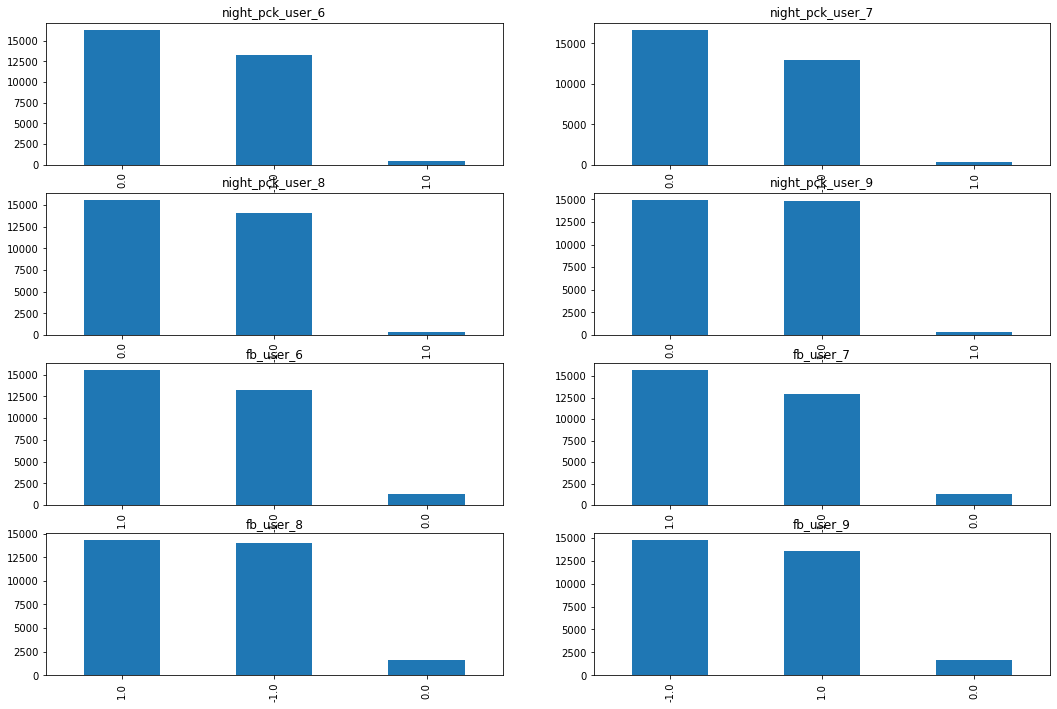

In [19]:
ROWS, COLS = 4, 2
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 12))
row, col = 0, 0
for i, category_columns_set in enumerate(category_columns_set):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    churn_data_hvc[category_columns_set].value_counts().plot('bar', ax=ax[row, col]).set_title(category_columns_set)

### <font color='lightcoral'>**Step 4: Churn Labelling (Target definition)**<font>
    - Calculate total incoming and outgoing minutes of usage
    - Calculate 2g and 3g data consumption
    - Craete churn variable: those who have not used either calls or internet in the month of September are customers who have churned
    - Check churn percentage
    - Delete columns that belong to churn month (9th month)

In [20]:
# calculate total incoming and outgoing minutes of usage
churn_data_hvc['total_calls_mou_9'] = churn_data_hvc.total_ic_mou_9 + churn_data_hvc.total_og_mou_9

In [21]:
# calculate 2g and 3g data consumption
churn_data_hvc['total_internet_mb_9'] =  churn_data_hvc.vol_2g_mb_9 + churn_data_hvc.vol_3g_mb_9

In [22]:
# create churn variable: those who have not used either calls or internet in the month of September are customers who have churned
# 0 - not churn, 1 - churn
churn_data_hvc['churn'] = churn_data_hvc.apply(lambda row: 1 if (row.total_calls_mou_9 == 0 and row.total_internet_mb_9 == 0) else 0, axis=1)

In [23]:
# delete derived variables
churn_data_hvc = churn_data_hvc.drop(['total_calls_mou_9', 'total_internet_mb_9'], axis=1)

Churn Ratio:
0   91.86
1    8.14
Name: churn, dtype: float64


There is data imbalance problem with data.


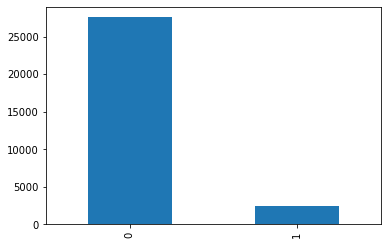

In [24]:
# change data type to category
churn_data_hvc.churn = churn_data_hvc.churn.astype("category")

# print churn ratio
print("Churn Ratio:")
print(churn_data_hvc.churn.value_counts()*100/churn_data_hvc.shape[0])
churn_data_hvc.churn.value_counts().plot('bar')
print("There is data imbalance problem with data.")

In [25]:
# drop all variables relating to 9th month
churn_data_hvc = churn_data_hvc.filter(regex='[^9]$', axis=1)
churn_data_hvc.shape

(30001, 167)

### Step 4: Inference
    - Churn labelling is done. (target variable)
    - There is an issue of data imbalance which needs to be handled during modelling.
    - Dropped all columns for 9th month to avoid any future data leakage in modelling.

### <font color='lightcoral'>**Step 5: Exploratory data analysis (EDA)**<font>
    - Treatment of missing values for HVC filter associated variables was done. Now,Missing value treatment for other attributes needs to be performed
    - Check variance of each column and drop columns without variance (single value columns).
    - Handling Date type columns and derive features based on dates.
    - Train/Test split for  modelling
    - Outlier analysis

In [26]:
# Check columns if there are any 9th month attributes.
pd.DataFrame(churn_data_hvc.columns)

,0
0,mobile_number
1,circle_id
2,loc_og_t2o_mou
3,std_og_t2o_mou
4,loc_ic_t2o_mou
5,last_date_of_month_6
6,last_date_of_month_7
7,last_date_of_month_8
8,arpu_6
9,arpu_7


In [27]:
# we are still left with few missing values in data. 
# churn_data_hvc is final table and missing values need to be treated carefully based on each attribute from here.
missing_values_table(churn_data_hvc)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Your selected dataframe has 167 columns.
There are 95 columns that have missing values.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,Missing Values,% of Total Values
loc_og_t2m_mou_8,1174,3.90
std_ic_t2m_mou_8,1174,3.90
std_ic_t2t_mou_8,1174,3.90
std_og_mou_8,1174,3.90
loc_ic_mou_8,1174,3.90
loc_og_t2f_mou_8,1174,3.90
loc_ic_t2f_mou_8,1174,3.90
loc_og_t2c_mou_8,1174,3.90
loc_ic_t2m_mou_8,1174,3.90
loc_og_mou_8,1174,3.90


### Check variance in each column and drop columns with zero variance

In [28]:
# Identify columns that have no varience
telecom_unique_count = churn_data_hvc.nunique().sort_values(ascending=False)

# Identify bad colums that has no infromation (all entries are NA or same)
# Find columns with all NULL entries and add to drop_columns list
telecom_unique_count_is_zero = telecom_unique_count[telecom_unique_count == 0]
print("Dataframe Unique Value Count is ZERO (all null values): \n", telecom_unique_count_is_zero)

drop_no_varience_columns = list(telecom_unique_count_is_zero.index)

# Find columns with all same entries and add to drop_columns list
telecom_unique_count_is_one = telecom_unique_count[telecom_unique_count == 1]
print("Dataframe Unique Value Count is ONE (all same values): \n", telecom_unique_count_is_one)
drop_no_varience_columns += list(telecom_unique_count_is_one.index)

churn_data_hvc.drop(drop_no_varience_columns, axis=1, inplace=True)

print('Number of columns dropped here  = ', len(drop_no_varience_columns))
print('Dataframe Shape: ', churn_data_hvc.shape)

Dataframe Unique Value Count is ZERO (all null values): 
 Series([], dtype: int64)
Dataframe Unique Value Count is ONE (all same values): 
 std_og_t2c_mou_7        1
std_ic_t2o_mou_7        1
std_ic_t2o_mou_8        1
std_og_t2c_mou_8        1
std_ic_t2o_mou_6        1
last_date_of_month_8    1
last_date_of_month_7    1
last_date_of_month_6    1
loc_ic_t2o_mou          1
std_og_t2o_mou          1
loc_og_t2o_mou          1
circle_id               1
std_og_t2c_mou_6        1
dtype: int64
Number of columns dropped here  =  13
Dataframe Shape:  (30001, 154)


In [29]:
# sum it up to check how many rows have all missing values
print("Rows with all NULL values =",  churn_data_hvc.isnull().all(axis=1).sum())

# sum of misisng values in each row
rows_missing_data = churn_data_hvc.isnull().sum(axis=1)
rows_missing_data[rows_missing_data > 0]

Rows with all NULL values = 0


0        54
77       27
91        1
111      27
188      28
         ..
99672     1
99700    27
99790    55
99827    27
99851    56
Length: 1838, dtype: int64

In [30]:
# small percentage of rows has more than or equal to 27 missing values
drop_rows = churn_data_hvc.isnull().sum(axis=1) >= 27
print("Number of rows with >= 27 missing values = {}".format(drop_rows.sum()))
print("     % of rows with >= 27 missing values = {} %".format(drop_rows.sum()/churn_data_hvc.shape[0]*100))

# drop rows with missing values greater >= 27
churn_data_hvc = churn_data_hvc[churn_data_hvc.isnull().sum(axis=1) < 27]
print('Dataframe Shape after dropping rows: ', churn_data_hvc.shape)

Number of rows with >= 27 missing values = 1497
     % of rows with >= 27 missing values = 4.989833672210926 %
Dataframe Shape after dropping rows:  (28504, 154)


In [31]:
missing_values_table(churn_data_hvc)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Your selected dataframe has 154 columns.
There are 3 columns that have missing values.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,Missing Values,% of Total Values
date_of_last_rech_8,276,1.00
date_of_last_rech_7,52,0.20
date_of_last_rech_6,33,0.10


In [32]:
# covert date columns to python datetime format
date_vars = ["date_of_last_rech_6",  "date_of_last_rech_7", "date_of_last_rech_8"]
churn_data_hvc[date_vars].head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
7,2014-06-27,2014-07-25,2014-08-26
8,2014-06-25,2014-07-31,2014-08-30
21,2014-06-30,2014-07-31,2014-08-31
23,2014-06-18,2014-07-07,2014-08-24
33,2014-06-30,2014-07-30,2014-08-26


In [33]:
# convert to datetime
for col in date_vars:
    churn_data_hvc[col] = pd.to_datetime(churn_data_hvc[col])

print(churn_data_hvc[date_vars].info())
churn_data_hvc[date_vars].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28504 entries, 7 to 99997
Data columns (total 3 columns):
date_of_last_rech_6    28471 non-null datetime64[ns]
date_of_last_rech_7    28452 non-null datetime64[ns]
date_of_last_rech_8    28228 non-null datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 890.8 KB
None


,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
7,2014-06-27,2014-07-25,2014-08-26
8,2014-06-25,2014-07-31,2014-08-30
21,2014-06-30,2014-07-31,2014-08-31
23,2014-06-18,2014-07-07,2014-08-24
33,2014-06-30,2014-07-30,2014-08-26


### <font color='lightcoral'>**Step 6: Derive new features**<font>
    - Treatment of missing values for HVC filter associated variables was done. Now,Missing value treatment for other attributes needs to be performed
    - Check variance of each column and drop columns without variance (single value columns).
    - Handling Date type columns and derive features based on dates.

### Derived features : - Based on date columns

In [34]:
# Create new days columns, instead of date
import datetime
last_date_of_month_6 = datetime.datetime.strptime("30-06-2014", "%d-%m-%Y")
last_date_of_month_7 = datetime.datetime.strptime("31-07-2014", "%d-%m-%Y")
last_date_of_month_8 = datetime.datetime.strptime("31-08-2014", "%d-%m-%Y")

churn_data_hvc["rech_days_left_6"]      = (last_date_of_month_6 - churn_data_hvc.date_of_last_rech_6).astype('timedelta64[D]')
churn_data_hvc["rech_days_left_7"]      = (last_date_of_month_7 - churn_data_hvc.date_of_last_rech_7).astype('timedelta64[D]')
churn_data_hvc["rech_days_left_8"]      = (last_date_of_month_8 - churn_data_hvc.date_of_last_rech_8).astype('timedelta64[D]')

day_columns = ["rech_days_left_6", "rech_days_left_7", "rech_days_left_8"]

print(churn_data_hvc[day_columns].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28504 entries, 7 to 99997
Data columns (total 3 columns):
rech_days_left_6    28471 non-null float64
rech_days_left_7    28452 non-null float64
rech_days_left_8    28228 non-null float64
dtypes: float64(3)
memory usage: 890.8 KB
None


In [35]:
# Drop all old date columns: add dates columns to drop_column list
churn_data_hvc.drop(date_vars, axis=1, inplace=True)
print('Dataframe Shape: ', churn_data_hvc.shape)

Dataframe Shape:  (28504, 154)


In [36]:
# Mean & Median are different: imputing with median value for recharge days left 
churn_data_hvc.loc[np.isnan(churn_data_hvc['rech_days_left_6']), ['rech_days_left_6']] = churn_data_hvc['rech_days_left_6'].median()
churn_data_hvc.loc[np.isnan(churn_data_hvc['rech_days_left_7']), ['rech_days_left_7']] = churn_data_hvc['rech_days_left_7'].median()
churn_data_hvc.loc[np.isnan(churn_data_hvc['rech_days_left_8']), ['rech_days_left_8']] = churn_data_hvc['rech_days_left_8'].median()


In [37]:
missing_values_table(churn_data_hvc)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Your selected dataframe has 154 columns.
There are 0 columns that have missing values.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,Missing Values,% of Total Values


### Derived features:- Based on revenue columns

In [38]:
# clubbing 2g and 3g data at monthly level.
churn_data_hvc['arpu_data_6'] = churn_data_hvc['arpu_3g_6'] + churn_data_hvc['arpu_2g_6']
churn_data_hvc['arpu_data_7'] = churn_data_hvc['arpu_3g_7'] + churn_data_hvc['arpu_2g_7']
churn_data_hvc['arpu_data_8'] = churn_data_hvc['arpu_3g_8'] + churn_data_hvc['arpu_2g_8']


# Drop variables used in derived features to avoid correlation
churn_data_hvc.drop(['arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8'], axis=1, inplace=True)

### Derived features:- Based on good phase and action phase
Understanding Customer Behaviour During Churn
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

**The ‘good’ phase:** In this phase, the customer is happy with the service and behaves as usual.

**The ‘action’ phase:** The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)


In [39]:
churn_data_hvc['arpu_diff'] = churn_data_hvc.arpu_8 - ((churn_data_hvc.arpu_6 + churn_data_hvc.arpu_7)/2)
churn_data_hvc['onnet_mou_diff'] = churn_data_hvc.onnet_mou_8 - ((churn_data_hvc.onnet_mou_6 + churn_data_hvc.onnet_mou_7)/2)
churn_data_hvc['offnet_mou_diff'] = churn_data_hvc.offnet_mou_8 - ((churn_data_hvc.offnet_mou_6 + churn_data_hvc.offnet_mou_7)/2)
churn_data_hvc['roam_ic_mou_diff'] = churn_data_hvc.roam_ic_mou_8 - ((churn_data_hvc.roam_ic_mou_6 + churn_data_hvc.roam_ic_mou_7)/2)
churn_data_hvc['roam_og_mou_diff'] = churn_data_hvc.roam_og_mou_8 - ((churn_data_hvc.roam_og_mou_6 + churn_data_hvc.roam_og_mou_7)/2)
churn_data_hvc['loc_og_mou_diff'] = churn_data_hvc.loc_og_mou_8 - ((churn_data_hvc.loc_og_mou_6 + churn_data_hvc.loc_og_mou_7)/2)
churn_data_hvc['std_og_mou_diff'] = churn_data_hvc.std_og_mou_8 - ((churn_data_hvc.std_og_mou_6 + churn_data_hvc.std_og_mou_7)/2)
churn_data_hvc['isd_og_mou_diff'] = churn_data_hvc.isd_og_mou_8 - ((churn_data_hvc.isd_og_mou_6 + churn_data_hvc.isd_og_mou_7)/2)
churn_data_hvc['spl_og_mou_diff'] = churn_data_hvc.spl_og_mou_8 - ((churn_data_hvc.spl_og_mou_6 + churn_data_hvc.spl_og_mou_7)/2)
churn_data_hvc['total_og_mou_diff'] = churn_data_hvc.total_og_mou_8 - ((churn_data_hvc.total_og_mou_6 + churn_data_hvc.total_og_mou_7)/2)
churn_data_hvc['loc_ic_mou_diff'] = churn_data_hvc.loc_ic_mou_8 - ((churn_data_hvc.loc_ic_mou_6 + churn_data_hvc.loc_ic_mou_7)/2)
churn_data_hvc['std_ic_mou_diff'] = churn_data_hvc.std_ic_mou_8 - ((churn_data_hvc.std_ic_mou_6 + churn_data_hvc.std_ic_mou_7)/2)
churn_data_hvc['isd_ic_mou_diff'] = churn_data_hvc.isd_ic_mou_8 - ((churn_data_hvc.isd_ic_mou_6 + churn_data_hvc.isd_ic_mou_7)/2)
churn_data_hvc['spl_ic_mou_diff'] = churn_data_hvc.spl_ic_mou_8 - ((churn_data_hvc.spl_ic_mou_6 + churn_data_hvc.spl_ic_mou_7)/2)
churn_data_hvc['total_ic_mou_diff'] = churn_data_hvc.total_ic_mou_8 - ((churn_data_hvc.total_ic_mou_6 + churn_data_hvc.total_ic_mou_7)/2)
churn_data_hvc['total_rech_num_diff'] = churn_data_hvc.total_rech_num_8 - ((churn_data_hvc.total_rech_num_6 + churn_data_hvc.total_rech_num_7)/2)
churn_data_hvc['total_rech_amt_diff'] = churn_data_hvc.total_rech_amt_8 - ((churn_data_hvc.total_rech_amt_6 + churn_data_hvc.total_rech_amt_7)/2)
churn_data_hvc['max_rech_amt_diff'] = churn_data_hvc.max_rech_amt_8 - ((churn_data_hvc.max_rech_amt_6 + churn_data_hvc.max_rech_amt_7)/2)
#churn_data_hvc['total_rech_data_diff'] = churn_data_hvc.total_rech_data_8 - ((churn_data_hvc.total_rech_data_6 + churn_data_hvc.total_rech_data_7)/2)
churn_data_hvc['max_rech_data_diff'] = churn_data_hvc.max_rech_data_8 - ((churn_data_hvc.max_rech_data_6 + churn_data_hvc.max_rech_data_7)/2)
#churn_data_hvc['av_rech_amt_data_diff'] = churn_data_hvc.av_rech_amt_data_8 - ((churn_data_hvc.av_rech_amt_data_6 + churn_data_hvc.av_rech_amt_data_7)/2)
churn_data_hvc['vol_2g_mb_diff'] = churn_data_hvc.vol_2g_mb_8 - ((churn_data_hvc.vol_2g_mb_6 + churn_data_hvc.vol_2g_mb_7)/2)
churn_data_hvc['vol_3g_mb_diff'] = churn_data_hvc.vol_3g_mb_8 - ((churn_data_hvc.vol_3g_mb_6 + churn_data_hvc.vol_3g_mb_7)/2)

### Univariate Analysis

In [40]:
list(churn_data_hvc.columns)

['mobile_number',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_

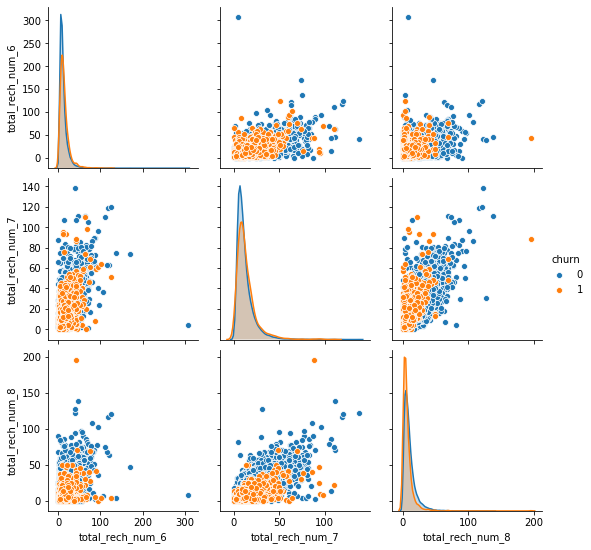

In [41]:
sns.pairplot(churn_data_hvc[['total_rech_num_6','total_rech_num_7','total_rech_num_8','churn']],hue ='churn' )

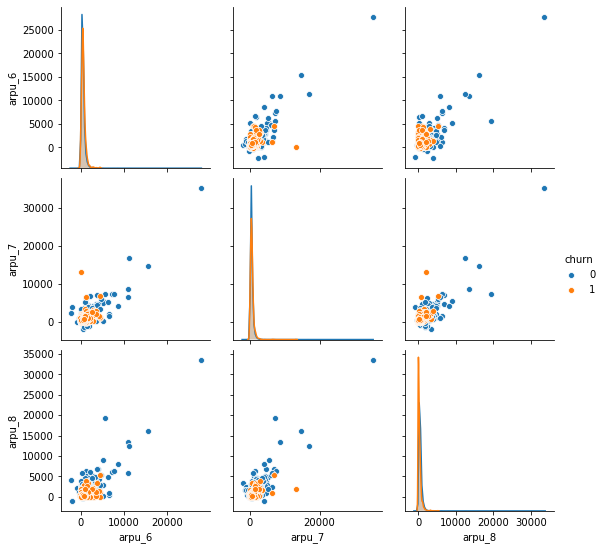

In [42]:
sns.pairplot(churn_data_hvc[['arpu_6','arpu_7','arpu_8','churn']],hue ='churn' )

### Bivariate Analysis

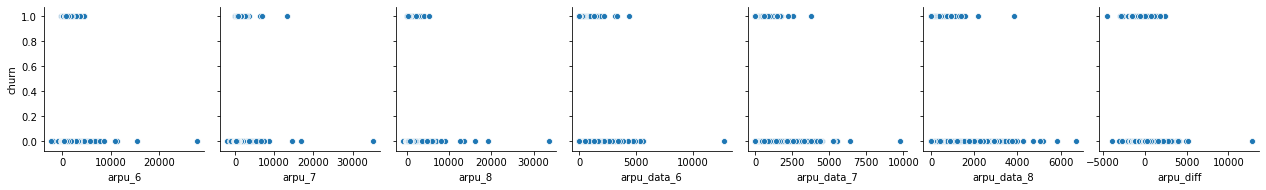

In [43]:
plot_rech_cols = [col for col in churn_data_hvc.columns if 'arpu' in col]
sns.pairplot(churn_data_hvc,
                 x_vars=plot_rech_cols,
                 y_vars=["churn"])

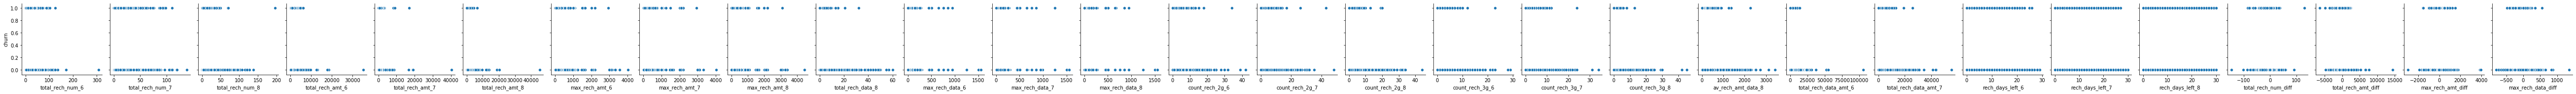

In [44]:
plot_rech_cols = [col for col in churn_data_hvc.columns if 'rech' in col]
sns.pairplot(churn_data_hvc,
                 x_vars=plot_rech_cols,
                 y_vars=["churn"])

No handles with labels found to put in legend.


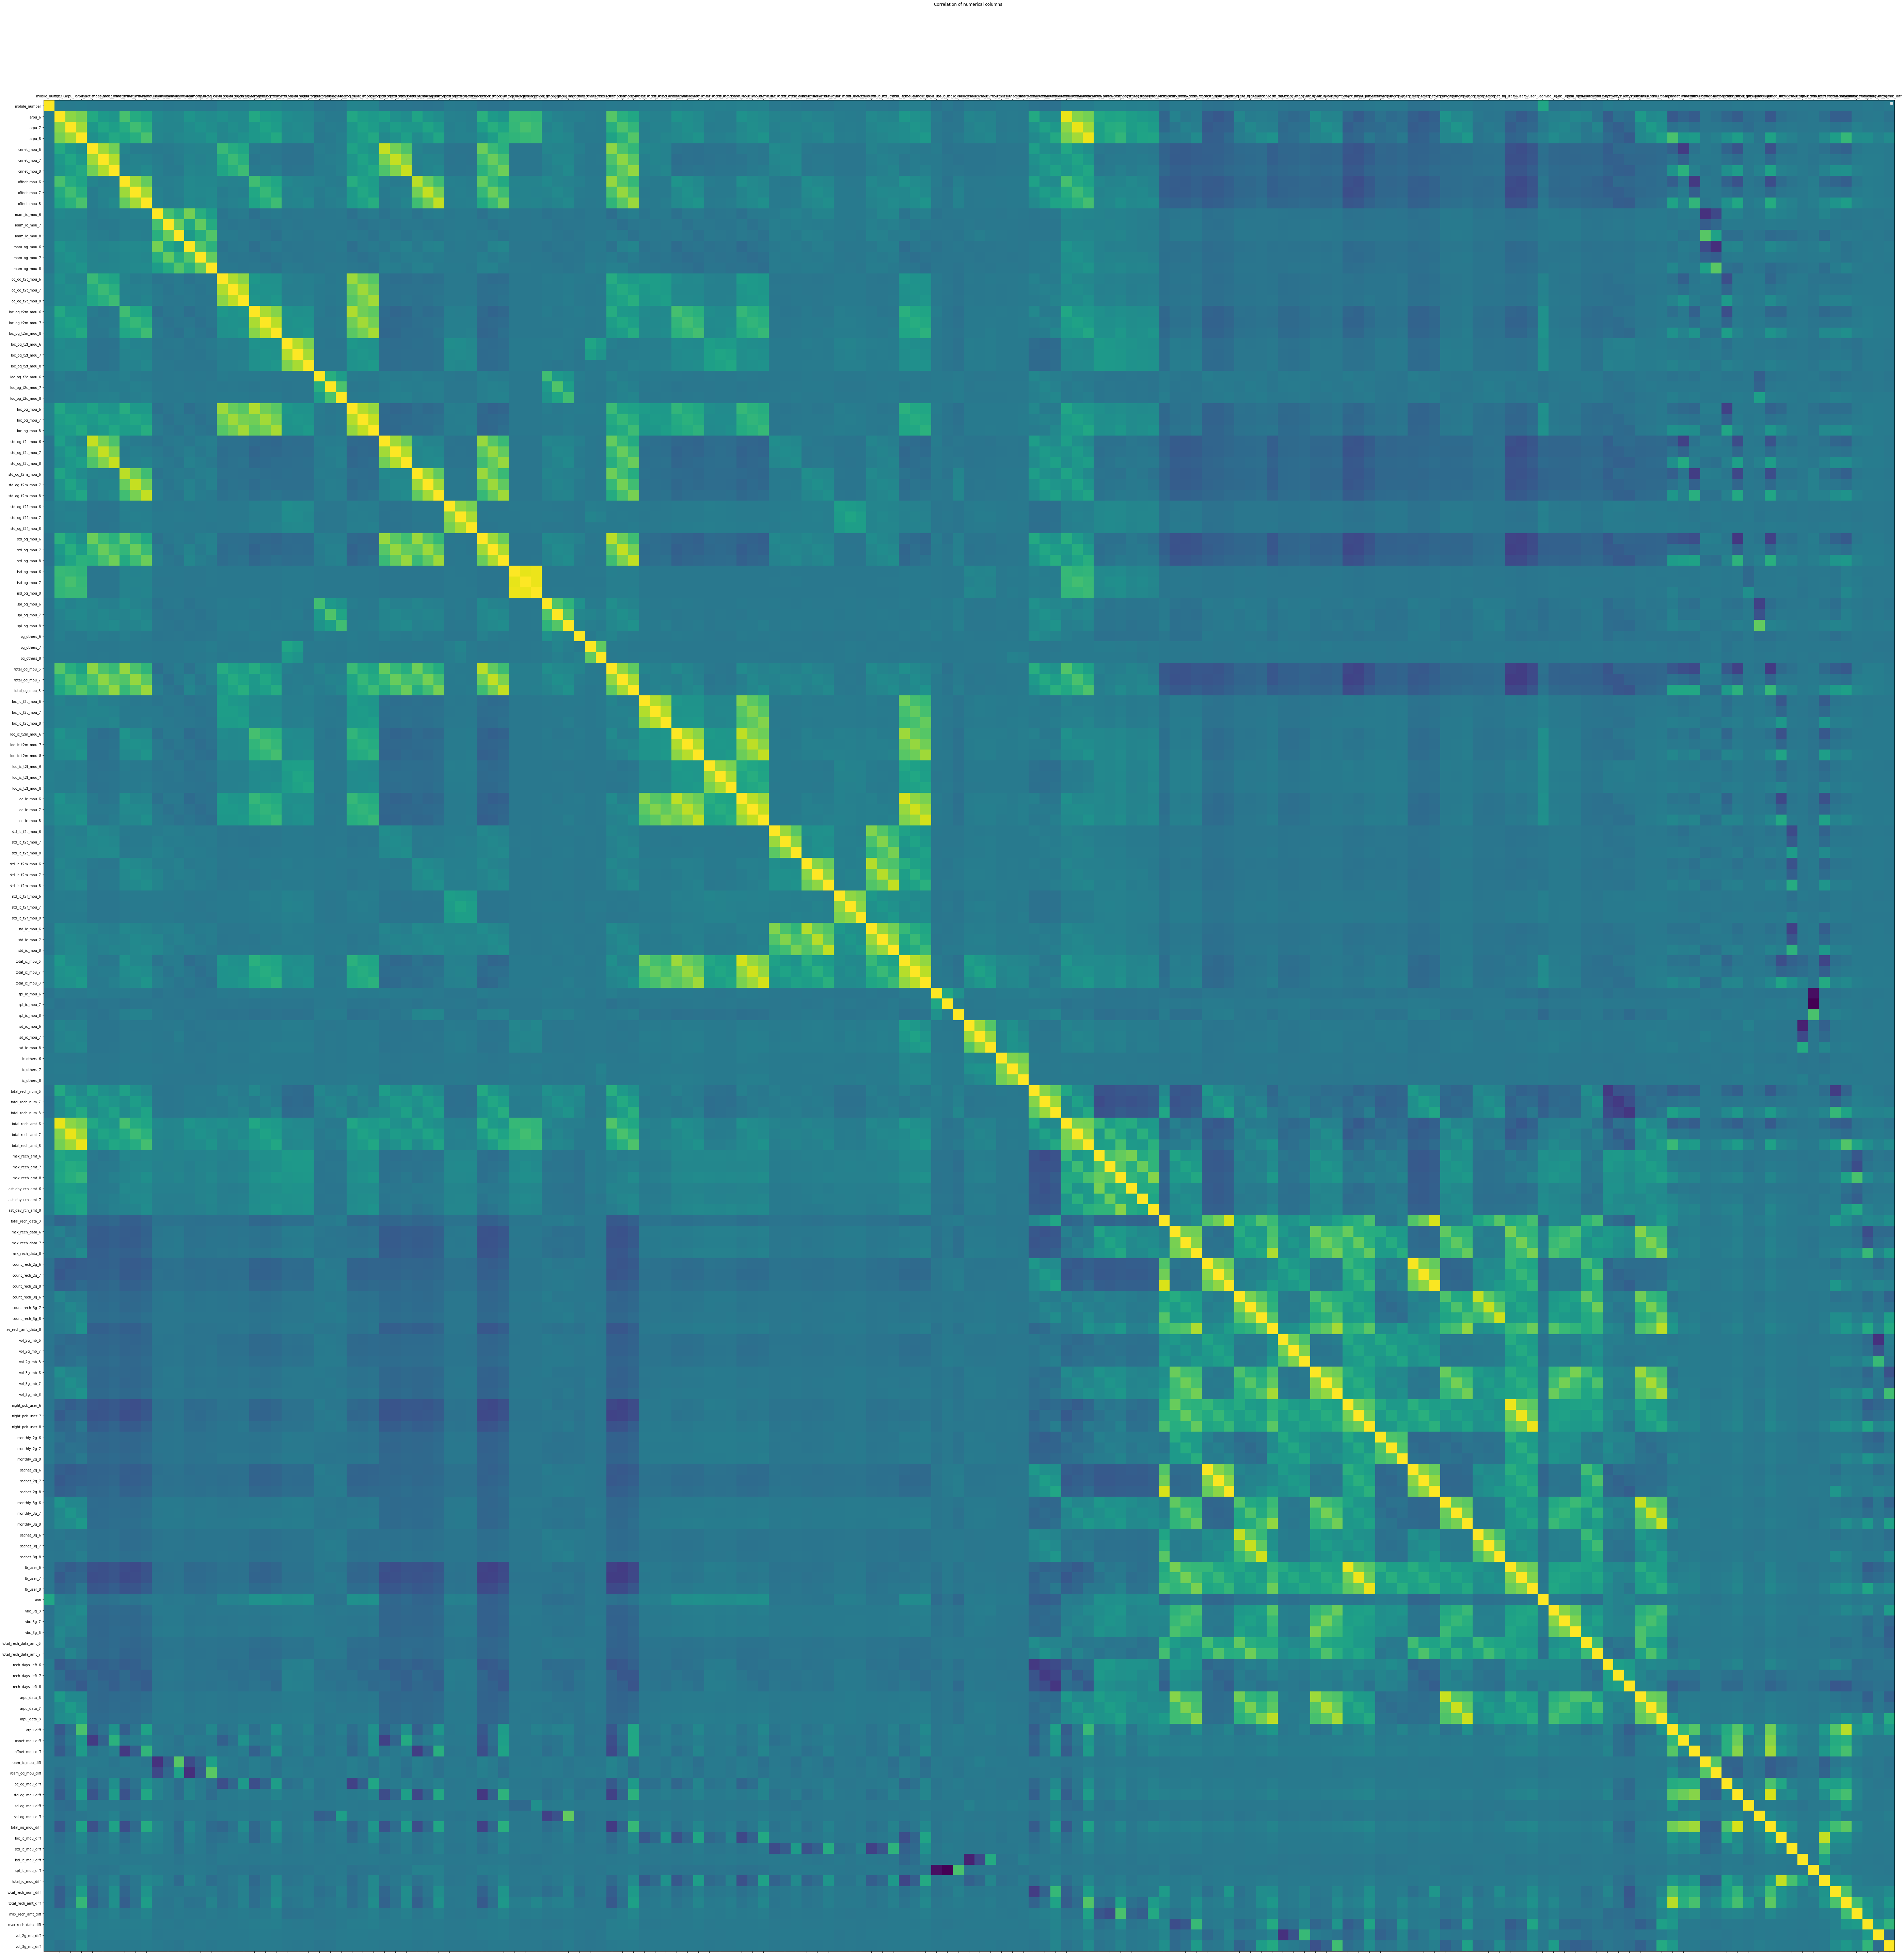

In [45]:
# Let's see the correlation matrix 
upper = churn_data_hvc._get_numeric_data().corr()

fig, ax = plt.subplots(figsize=(120, 100))
ax.matshow(upper)
plt.xticks(range(len(upper.columns)), upper.columns)
plt.yticks(range(len(upper.columns)), upper.columns)
ax.legend()
plt.title('Correlation of numerical columns ');
plt.show();

In [46]:
cdf=churn_data_hvc[(churn_data_hvc['churn']==1)]
ncdf=churn_data_hvc[(churn_data_hvc['churn']==0)]

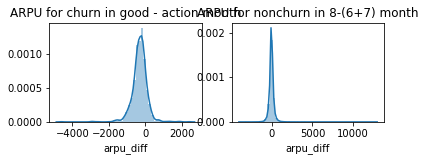

In [47]:

plt.subplot(223)
plt.title('ARPU for churn in good - action month')
sns.distplot(cdf.arpu_diff);

plt.subplot(224)
plt.title('ARPU for nonchurn in 8-(6+7) month')
sns.distplot(ncdf.arpu_diff);

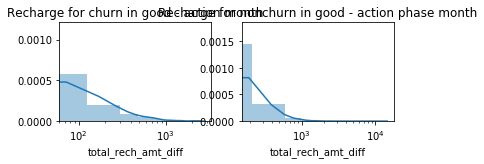

In [48]:
plt.subplot(223);
plt.title('Recharge for churn in good - action month');
sns.distplot(cdf.total_rech_amt_diff);
plt.xscale('log');

plt.subplot(224)
plt.title('Recharge for nonchurn in good - action phase month');
sns.distplot(ncdf.total_rech_amt_diff);
plt.xscale('log');

### Outlier treatment

In [49]:
pd.DataFrame(churn_data_hvc.columns)

,0
0,mobile_number
1,arpu_6
2,arpu_7
3,arpu_8
4,onnet_mou_6
5,onnet_mou_7
6,onnet_mou_8
7,offnet_mou_6
8,offnet_mou_7
9,offnet_mou_8


In [50]:
# Find outlier threshold for each variable based on k sigma technique
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [51]:
outlier_slctd_cols = list(set(churn_data_hvc.columns) - set(['churn','mobile_number']))
churn_data_hvc[outlier_slctd_cols] = churn_data_hvc[outlier_slctd_cols].apply(cap_outliers, axis=0)

In [52]:
# change churn to numeric
churn_data_hvc['churn'] = pd.to_numeric(churn_data_hvc['churn'])

### Train - Test split

In [53]:
# divide data into train and test
X = churn_data_hvc.drop(["churn","mobile_number"], axis = 1)
y = churn_data_hvc.churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 4, stratify = y)

In [ ]:
why have you used stratify?


In [54]:
# print shapes of train and test sets
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(22803, 170)

(22803,)

(5701, 170)

(5701,)

### Aggregating Categorical columns

In [55]:
train = pd.concat([X_train, y_train], axis=1)

# aggregate the categorical variables
train.groupby('night_pck_user_6').churn.mean()
train.groupby('night_pck_user_7').churn.mean()
train.groupby('night_pck_user_8').churn.mean()
train.groupby('fb_user_6').churn.mean()
train.groupby('fb_user_7').churn.mean()
train.groupby('fb_user_8').churn.mean()

night_pck_user_6
-1.00   0.07
0.00    0.04
1.00    0.06
Name: churn, dtype: float64

night_pck_user_7
-1.00   0.08
0.00    0.04
1.00    0.05
Name: churn, dtype: float64

night_pck_user_8
-1.00   0.09
0.00    0.02
1.00    0.02
Name: churn, dtype: float64

fb_user_6
-1.00   0.07
0.00    0.06
1.00    0.04
Name: churn, dtype: float64

fb_user_7
-1.00   0.08
0.00    0.05
1.00    0.04
Name: churn, dtype: float64

fb_user_8
-1.00   0.09
0.00    0.06
1.00    0.02
Name: churn, dtype: float64

In [56]:
# replace categories with aggregated values in each categorical column
mapping = {'night_pck_user_6' : {-1: 0.07, 0: 0.04, 1: 0.06},
           'night_pck_user_7' : {-1: 0.08, 0: 0.04, 1: 0.05},
           'night_pck_user_8' : {-1: 0.09, 0: 0.02, 1: 0.02},
           'fb_user_6'        : {-1: 0.07, 0: 0.06, 1: 0.04},
           'fb_user_7'        : {-1: 0.08, 0: 0.05, 1: 0.04},
           'fb_user_8'        : {-1: 0.09, 0: 0.06, 1: 0.02}
          }
X_train.replace(mapping, inplace = True)
X_test.replace(mapping, inplace = True)

### <font color='lightcoral'>**Step 8: Modelling**<font>
    - Handling class imbalance problem
    - Logistic Regression
        - Using RFE variable selection
        - PCA analysis
        - Hyper- parameter tuning with PCA components
    - Random Forest  
    - Feature Importance

### Logistic Regression using RFE

In [57]:
estimator = LogisticRegression(class_weight='balanced')
rfe = RFE(estimator, n_features_to_select=20)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='auto', n_jobs=None, penalty='l2',
                                 random_state=None, solver='lbfgs', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=20, step=1, verbose=0)

In [58]:
X= pd.DataFrame(rfe.ranking_, columns=['rank'])
X['col']=X_train.columns
X=X.loc[(X['rank']==1),:]
rfelist =list(X.col)
rfelist

['roam_og_mou_8',
 'loc_og_t2f_mou_7',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2f_mou_8',
 'ic_others_6',
 'ic_others_8',
 'total_rech_num_7',
 'total_rech_num_8',
 'last_day_rch_amt_8',
 'total_rech_data_8',
 'count_rech_2g_8',
 'sachet_2g_7',
 'sachet_2g_8',
 'rech_days_left_8',
 'spl_og_mou_diff',
 'total_rech_num_diff']

In [59]:

X_train_lr = X_train[rfelist]
X_test_lr = X_test[rfelist]

from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(class_weight='balanced')
lr.fit(X_train_lr, y_train)
y_pred = lr.predict(X_test_lr)

from sklearn import metrics
print(metrics.accuracy_score( y_test, y_pred))
print(metrics.precision_score( y_test, y_pred))
print(metrics.f1_score( y_test, y_pred))
print(metrics.roc_auc_score( y_test, y_pred))
metrics.confusion_matrix(y_test, y_pred)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

0.7919663216979478
0.18564176939811458
0.30153121319199055
0.7969246728617043


array([[4259, 1123],
       [  63,  256]], dtype=int64)

### PCA

In [60]:
# apply pca to train data
pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])

In [61]:
pca.fit(X_train)
churn_pca = pca.fit_transform(X_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)

In [62]:
# extract pca model from pipeline
pca = pca.named_steps['pca']


<Figure size 630x360 with 0 Axes>

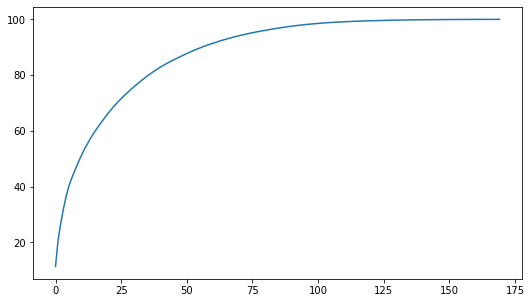

In [63]:
# plot feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(175/20,100/20)) # 100 elements on y-axis; 175 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)

~ 60 components explain 90% variance

~ 80 components explain 95% variance

### PCA and Logistic Regression

In [64]:
# create pipeline
PCA_VARS = 60
steps = [('scaler', StandardScaler()),
         ("pca", PCA(n_components=PCA_VARS)),
         ("logistic", LogisticRegression(class_weight='balanced'))
        ]
pipeline = Pipeline(steps)

In [65]:
# fit model
pipeline.fit(X_train, y_train)

# check score on train data
pipeline.score(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=60,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logistic',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

0.8116914441082314

In [66]:
# predict churn on test data
y_pred = pipeline.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[4374 1008]
 [  70  249]]
Sensitivity: 	0.78
Specificity: 	0.81
AUC:    	 0.87


### Hyperparameter tuning - PCA and Logistic Regression

In [67]:
# class imbalance
y_train.value_counts()/y_train.shape

0   0.94
1   0.06
Name: churn, dtype: float64

In [68]:
# PCA
pca = PCA()

# logistic regression - the class weight is used to handle class imbalance - it adjusts the cost function
logistic = LogisticRegression(class_weight={0:0.1, 1: 0.9})

# create pipeline
steps = [("scaler", StandardScaler()), 
         ("pca", pca),
         ("logistic", logistic)
        ]

# compile pipeline
pca_logistic = Pipeline(steps)

# hyperparameter space
params = {'pca__n_components': [60, 80], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=pca_logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [69]:
# fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('logistic',
                                        LogisticRegression(C=1.0,
                                                           c...
                          

In [70]:
# cross validation results
pd.DataFrame(model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.65,0.05,0.00,0.00,0.10,l1,60,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",nan,nan,nan,nan,nan,nan,nan,32
1,2.05,0.10,0.00,0.00,0.10,l1,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",nan,nan,nan,nan,nan,nan,nan,20
2,1.84,0.20,0.04,0.01,0.10,l2,60,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.89,0.87,0.87,0.89,0.89,0.88,0.01,11
3,1.94,0.05,0.05,0.01,0.10,l2,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.90,0.88,0.88,0.89,0.89,0.89,0.01,4
4,1.42,0.08,0.00,0.00,0.50,l1,60,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",nan,nan,nan,nan,nan,nan,nan,23
5,1.88,0.18,0.00,0.00,0.50,l1,80,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",nan,nan,nan,nan,nan,nan,nan,29
6,1.46,0.04,0.04,0.00,0.50,l2,60,"{'logistic__C': 0.5, 'logistic__penalty': 'l2'...",0.89,0.87,0.87,0.89,0.89,0.88,0.01,16
7,1.85,0.02,0.05,0.01,0.50,l2,80,"{'logistic__C': 0.5, 'logistic__penalty': 'l2'...",0.90,0.88,0.88,0.89,0.89,0.89,0.01,1
8,1.35,0.12,0.00,0.00,1,l1,60,"{'logistic__C': 1, 'logistic__penalty': 'l1', ...",nan,nan,nan,nan,nan,nan,nan,17
9,1.74,0.14,0.00,0.00,1,l1,80,"{'logistic__C': 1, 'logistic__penalty': 'l1', ...",nan,nan,nan,nan,nan,nan,nan,30


In [71]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.888347158907678
Best hyperparameters:  {'logistic__C': 0.5, 'logistic__penalty': 'l2', 'pca__n_components': 80}


In [72]:
# predict churn on test data
y_pred = model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[4815  567]
 [  89  230]]
Sensitivity: 	0.72
Specificity: 	0.89
AUC:    	 0.88


### Random forest

In [73]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)
print(metrics.accuracy_score( y_test, predictions))
print(metrics.precision_score( y_test, predictions))
print(metrics.f1_score( y_test, predictions))
print(metrics.roc_auc_score( y_test, predictions))
metrics.confusion_matrix(y_test, predictions)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

0.9486055078056481
0.625
0.3073286052009456
0.5982576893371496


array([[5343,   39],
       [ 254,   65]], dtype=int64)

### Random forest with Hyperparameter tuning

#### Tuning max depth

In [74]:
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'max_depth': range(4, 16, 2)}
# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')
# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="roc_auc",return_train_score=True)
rf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

{'max_depth': 10}


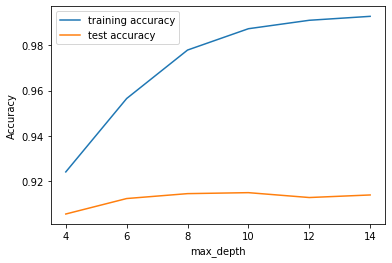

In [75]:
print(rf.best_params_)
scores = rf.cv_results_
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy");
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy");
plt.xlabel("max_depth");
plt.ylabel("Accuracy");
plt.legend();
plt.show();

#### Tuning n_estimators

In [77]:
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'n_estimators': range(10, 50, 10)}
# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')
# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="roc_auc",return_train_score=True)
rf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

{'n_estimators': 10}


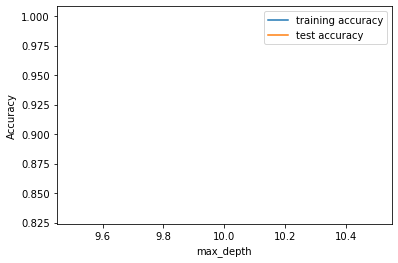

In [78]:
print(rf.best_params_)
scores = rf.cv_results_
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy");
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy");
plt.xlabel("max_depth");
plt.ylabel("Accuracy");
plt.legend();
plt.show();

#### Tuning max features

In [80]:
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on

parameters = {'max_features': [10, 25, 50, 75 , 100]}
# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')
# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="roc_auc",return_train_score=True)
rf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

{'max_features': 100}


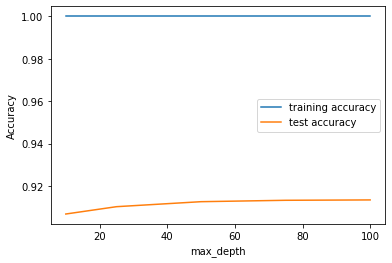

In [81]:
print(rf.best_params_)
scores = rf.cv_results_
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy");
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy");
plt.xlabel("max_depth");
plt.ylabel("Accuracy");
plt.legend();
plt.show();

In [83]:
# Create the parameter grid based on the results of random search  
param_grid = {     'max_depth': [6,8,10],
                   'n_estimators': [10,50,100],
                   'max_features': ['auto'] } 

# Create a based model 
rf = RandomForestClassifier() 

# Instantiate the grid search 
model_GSV = GridSearchCV(estimator = rf, param_grid = param_grid,cv = 3, n_jobs = -1,verbose = 1) 

# Fit the grid search to the data grid_search.fit(X_train, y_train) 
model_GSV.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   51.2s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [84]:
print('We can get accuracy of',model_GSV.best_score_,'using',model_GSV.best_params_)

We can get accuracy of 0.9495241854141999 using {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 10}


In [96]:
# model with the best hyperparameters from sklearn.ensemble
rfc_best = RandomForestClassifier(bootstrap=True,         max_depth=8,
                                                           max_features='auto',
                                                           n_estimators=10,
                                                           class_weight={0:0.9,1:0.9}) 
rfc_best.fit(X_train,y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.9, 1: 0.9}, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [97]:
# Making predictions
predictions_inc = rfc_best.predict(X_test)

In [98]:
print(metrics.classification_report(y_test,predictions_inc))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5382
           1       0.65      0.23      0.33       319

    accuracy                           0.95      5701
   macro avg       0.80      0.61      0.65      5701
weighted avg       0.94      0.95      0.94      5701



### Feature Importance

In [95]:
import pandas as pd
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
(feature_importances)

,importance
total_ic_mou_8,0.04
roam_ic_mou_8,0.03
loc_ic_t2m_mou_8,0.03
total_rech_amt_diff,0.03
loc_ic_t2t_mou_8,0.03
total_og_mou_diff,0.03
rech_days_left_8,0.03
arpu_diff,0.03
last_day_rch_amt_8,0.02
roam_og_mou_8,0.02


### Applying SMOTE and trying Random Forest

In [101]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_tr,y_tr = sm.fit_sample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)
np.count_nonzero(y_tr)
y_tr.value_counts()

(43052, 170)
(43052,)


21526

1    21526
0    21526
Name: churn, dtype: int64

In [102]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_tr,y_tr)
predictions = rfc.predict(X_test)
print(metrics.accuracy_score( y_test, predictions))
print(metrics.precision_score( y_test, predictions))
print(metrics.f1_score( y_test, predictions))
print(metrics.roc_auc_score( y_test, predictions))
metrics.confusion_matrix(y_test, predictions)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

0.9429924574636028
0.49050632911392406
0.4881889763779528
0.7279894435066848


array([[5221,  161],
       [ 164,  155]], dtype=int64)

In [103]:
# model with the best hyperparameters from sklearn.ensemble
rfc_best_smote = RandomForestClassifier(bootstrap=True,         max_depth=8,
                                                           max_features='auto',
                                                           n_estimators=10
                                                           ) 
rfc_best_smote.fit(X_tr,y_tr) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [104]:
# Making predictions
predictions_inc = rfc_best.predict(X_test)

In [105]:
print(metrics.classification_report(y_test,predictions_inc))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5382
           1       0.65      0.23      0.33       319

    accuracy                           0.95      5701
   macro avg       0.80      0.61      0.65      5701
weighted avg       0.94      0.95      0.94      5701



### Modelling Inference
- Tried implicit balance parameter and SMOTE analysis to handle imbalance problem
- Hyper parameter tuning Logistic regression giving good performance.
    -Logistic Regresssion model with AUC = 88% (Recall and Precsion close to 82 %)

### <font color='lightcoral'>**Step 10: Insights & Recommendations**<font>
    - Telecom company needs to pay attention to the roaming rates. They need to provide good offers to the customers who are using services from a roaming zone.
    - Monitor the total recharge, offer additional talk time with additional validity on the recharges
    - Based on the usage / last recharge, if the usage is less compared to previous months, speak to the customer to know his concerns.
    
Finally, recommendation to the telecom service provider would be to focus on feedback and compliants from customers and understand the concerns with services.    
    

# ANOTHER APPROACH TO THE PROBLEM STATEMENT

## Step1: Importing and Reading Data into DataFrame

In [ ]:
#Import statments are same as for the above approach , however repeated for user's ease of view and understanding 

# Importing Pandas and NumPy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import os
import re

%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)

In [ ]:
# Importing  dataset
telecom_data = pd.read_csv("telecom_churn_data.csv",encoding = 'ISO-8859-1', low_memory=False)
telecom_data_copy = telecom_data.copy()

In [ ]:
# Let's see the head of our master dataset
telecom_data.head()

In [ ]:
telecom_data.info(verbose = 1)

In [ ]:
telecom_data.shape

In [ ]:
#Checking for duplicate rows
telecom_data_update = telecom_data.drop_duplicates() 

print(telecom_data.shape)
print(telecom_data_update.shape)

Checking for duplicate rows and none found

In [ ]:
#Droppinng rows with 70% null values
columnlist=list(telecom_data.columns)
missing_data=round(100*(telecom_data.isnull().sum(axis=1)/len(columnlist)),2)

drop_missing_values_rows=missing_data[missing_data  > 70].index

telecom_data.drop(drop_missing_values_rows,axis=0,inplace=True)

print(" No. of rows dropped :" ,len(drop_missing_values_rows))
print("New dataframe shape :",telecom_data.shape)

In [ ]:
telecom_data.describe()

In [ ]:
# Reading the columns of telecom data
columnlist=list(telecom_data.columns)
columnlist

In [ ]:
#Checking unique values in each column to help us better understand missing values and data
telecom_data.apply(pd.Series.nunique, axis = 0).sort_values(ascending=False)

In [ ]:
#Function that takes dataframe name as arg and gives list of its column missing values and its missing percentage
#its same as above in the file , however repeated for ease of reading

print(missing_values_table(telecom_data))

In [ ]:
#Function to count the unique values and represent them as percentages for the column name passed as arg.

def count_summary(x):
    mis_val = telecom_data[x].isnull().sum()
    mis_val_percent = (100 * telecom_data[x].isnull().sum() / len(telecom_data[x])).round(1)
    print(f"Missing value {mis_val} and its missing percentage :{mis_val_percent}")
    count= telecom_data[x].value_counts()
    pct = telecom_data[x].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    x_count_summary = pd.DataFrame({'Counts': count, 'Pct': pct}).reset_index().sort_values(by = 'index')
    return x_count_summary

## Step2 : Handling Missing data and Imputing values

### Running univariate and bivariate analysis

In [ ]:
Breaking down the column list into segments to understand data more , see patterns and understand what values need to be imputed. 
Starting with month 6 part of good phase:

In [ ]:
month6list = [x for x in columnlist if re.match(r'.*6$',x)]
month6list

In [ ]:
month6_df = pd.DataFrame(telecom_data[month6list])
month6_df.head(250)

In [ ]:
# checking the data types of each column , and verifying the need if any to convert date variables to datetime objects
month6_df.info()

We have 54 columns related to month6

In [ ]:
month6_df.describe()

In [ ]:
print(missing_values_table(month6_df))

Checking rows where date_of_last_rech_6 is null , to see customer usage of that mobile number

In [ ]:
no_rech_voice = month6_df.loc[month6_df.date_of_last_rech_6.isnull()]
no_rech_voice.head(100)

In [ ]:
print(len(no_rech_voice.index))

In [ ]:
no_rech_voice_data = month6_df.loc[month6_df.date_of_last_rech_6.isnull() & month6_df.date_of_last_rech_data_6.isnull() ]
print(len(no_rech_voice_data.index))

As can be seen from above , the missing data for date_of_last_rech_6 is 1.4 % ,
but these customers have not recharged for call or interent service , so the missing values can be taken as zero . 
These customers will mostly however be filtered out for HVC.

Obsereving which day the customers usually recharge for voice

In [ ]:
#Converting to datetime objects
month6_df['date_of_last_rech_data_6']=pd.to_datetime(month6_df['date_of_last_rech_data_6'])
month6_df['date_of_last_rech_6']=pd.to_datetime(month6_df['date_of_last_rech_6'])
month6_df['last_date_of_month_6']=pd.to_datetime(month6_df['last_date_of_month_6'])

In [ ]:
count = month6_df['date_of_last_rech_6'].value_counts()
pct = month6_df['date_of_last_rech_6'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
date_of_last_rech_6_summary = pd.DataFrame({'Counts': count, 'Pct': pct}).reset_index()
date_of_last_rech_6_summary

In [ ]:
plt.axis('equal')
plt.pie(date_of_last_rech_6_summary['Counts'], 
        labels = date_of_last_rech_6_summary["index"], 
        radius = 1,
        shadow=False, 
        startangle=60, 
        autopct='%1.1f%%')
plt.title('Distribution of customer Preference of Recharge in last week of month')
plt.show()

1. 17% of people recharge on the last date of the month 6
2. 65% of people recharge in the last week of the month 6

Inference:
1.Three Columns contribute to the amount spend by a customer to recharge his mobile no. , total_rech_amt_6,
total_rech_data_6 and avg_rech_amt_data , for calls and internet purpose resp.,hence a new column needs to be         made to give us the total amount recharged in month of 6.

2.Nan values basically represent that the service wasnt availed by the customer , hence can be imputed as 0.

3.As satated above arpu (Average revenue per user) is given by sum of arpu_6 for call usage and arpu_3g_6 and         arpu_2g_6 for 3g and 2g use respectively , as shown by the data a customer can at a time utilise all three           simultaneously.ARPU is a great tool to evaluate if you have the resources to acquire the needed customers and         make your business a success.

3.a.There are certain arpu values that aer negative , these need to be handled as it cannot be negative value, The formula for average revenue per user is

ARPU = Total Revenue / Number of Subscribers
For this reason we ignore them , coz we take only HVC

4.Total_rech_data = Count_rech_2g(monthly+sachet)+count_rech_3g(monthly+sachet) , and similar patters and correlation can be observed , will see in detail later.

5.Last_date_of_month_6 can be deleted due to zero variance.

6.A customer doesnt have to rechrge his internet service to use it , this maybe due to some already existing free internet plans or carryover from previous month data , however it cannot be assumed that if the customer doesnt recharge there will be no internet usage or no arpu , as proven by data.

7.There are rows having all but one or two columns values as zero or nan , these have to be removed.

8.Date columns are object type have to be formatted to date type and nan values to be handled.

9.If the avr_rech_amt_data coulmn has none value the customer doesnt utilize internet service , hence all related columns have nan values , which can also be imputed as zero.

Now seperating Customers who are non-net users from the rest for later deep analysis

In [ ]:
non_net_user = month6_df.loc[month6_df.av_rech_amt_data_6.apply(pd.to_numeric) == 0.00 ]
print(len(non_net_user.index))

Its seen that the missing values are due to non net users , these values hence can be imputed as zero.

 **Same pattern are observed for month 7 and 8**

In [ ]:
month7list = [x for x in columnlist if re.match(r'.*7$',x)]
month7list

In [ ]:
month7_df = pd.DataFrame(telecom_data[month7list])
month7_df.head(250)

In [ ]:
print(missing_values_table(month7_df))

In [ ]:
no_rech_voice = month7_df.loc[month7_df.date_of_last_rech_7.isnull()]
no_rech_voice.head(100)

In [ ]:
print(len(no_rech_voice.index))

In [ ]:
no_rech_voice_data = month7_df.loc[month7_df.date_of_last_rech_7.isnull() & month7_df.date_of_last_rech_data_7.isnull() ]
print(len(no_rech_voice_data.index))

Same pattern as month6

In [ ]:
month8list = [x for x in columnlist if re.match(r'.*8$',x)]
month8list

In [ ]:
month8_df = pd.DataFrame(telecom_data[month8list])
month8_df.head(250)

In [ ]:
print(missing_values_table(month8_df))

In [ ]:
no_rech_voice = month8_df.loc[month8_df.date_of_last_rech_8.isnull()]
no_rech_voice.head(100)

In [ ]:
print(len(no_rech_voice.index))

In [ ]:
no_rech_voice_data = month8_df.loc[month8_df.date_of_last_rech_8.isnull() & month8_df.date_of_last_rech_data_8.isnull() ]
print(len(no_rech_voice_data.index))

In [ ]:
Same pattern as month6

AON :
    Age on Network of the customer

In [ ]:
aonlist = [x for x in columnlist if re.match(r'.*aon$',x)]
aonlist

In [ ]:
telecom_data['aon'].describe()

In [ ]:
count_summary('circle_id')
print("All Customers in the Data provided belong to same area hence this column is deleted.")

Checking summary of these categorical values , and deciding not to use dummy variable or label encoder as 
these are 0/1 level only.Imputing their missing values to zero , as most of them belong to non net user customers.

In [ ]:
count_summary('night_pck_user_6')
count_summary('night_pck_user_8')
count_summary('night_pck_user_7')

count_summary('fb_user_6')
count_summary('fb_user_7')
count_summary('fb_user_8')

In [ ]:
#Consequently checking the summary of Following variables and deciding to impute missing values as zer0.
# Checking the summary .
count_summary('std_ic_t2o_mou_6')
count_summary('std_og_t2c_mou_7')
count_summary('std_og_t2c_mou_8')
count_summary('std_og_t2c_mou_9')
count_summary('std_og_t2c_mou_6')
count_summary('last_date_of_month_9')
count_summary('last_date_of_month_8')
count_summary('last_date_of_month_7')
count_summary('last_date_of_month_6')
count_summary('loc_ic_t2o_mou')
count_summary('std_og_t2o_mou')
count_summary('loc_og_t2o_mou')
#similarly study of each variable was carried out seperately.

In [ ]:
#The assumption for this approach is that date columns are not contributing much to churn hence will be ignored.
#Seperating the date columns before filling NAN 
date_list = [
             'last_date_of_month_6',
             'last_date_of_month_7',
             'last_date_of_month_8',
             'last_date_of_month_9',
             'date_of_last_rech_6',
             'date_of_last_rech_7',
             'date_of_last_rech_8',
             'date_of_last_rech_9',
             'last_day_rch_amt_6',
             'last_day_rch_amt_7',
             'last_day_rch_amt_8',
             'last_day_rch_amt_9',
             'date_of_last_rech_data_6',
             'date_of_last_rech_data_7',
             'date_of_last_rech_data_8',
             'date_of_last_rech_data_9'
                                        ]

In [ ]:
#Seperating ARPU columns as these values are calculated for all the customers per month , here as we are only 
#concentrating on HVC we can ignore them for now.
arpu_list =[
                     'arpu_3g_6',
                     'arpu_3g_7',
                     'arpu_3g_8',
                     'arpu_3g_9',
                     'arpu_2g_6',
                     'arpu_2g_7',
                     'arpu_2g_8',
                     'arpu_2g_9',
                     'arpu_6',
                     'arpu_7',
                     'arpu_8',
                     'arpu_9'
                                ]

In [ ]:
#Columns on inspection found to have max zero values on inspection or have same single value
all_zero = [
             'circle_id',
             'loc_og_t2o_mou',
             'std_og_t2o_mou',
             'loc_ic_t2o_mou',
             'std_og_t2c_mou_6',
             'std_og_t2c_mou_7',
             'std_og_t2c_mou_8',
             'std_og_t2c_mou_9',
             'std_ic_t2o_mou_6',
             'std_ic_t2o_mou_7',
             'std_ic_t2o_mou_8',
             'std_ic_t2o_mou_9'
                                ]

In [ ]:
#Total number of columns being dropped.
all_drop_list=date_list+arpu_list+all_zero
print(len(all_drop_list))

In [ ]:
churn_data = telecom_data.drop(all_drop_list, axis =1)
churn_data.shape

In [ ]:
#imputing all missing and nan values as 0
churn_data = churn_data.apply(pd.to_numeric, errors='coerce').fillna(0, downcast='infer')

In [ ]:
churn_data.describe()

In [ ]:
churn_data.quantile([ .1,.15,.2,.75,.80,.85,.90,.95,.97], axis = 0)

## Step 3 : Renaming and Deriving new columns 

Customers who have recharged with an amount more than or equal to X, where X is the 70th percentile of the 
average recharge amount in the first two months 6 & 7(the good phase).
Creating two new columns and at end deleting all the columns that led to this calculation and keeping 
these as derived columns , anyway the original columns can be thought of as linearly dependant ones and removed.

Renaming a few columns for better understanding 

In [ ]:
churn_data['vbc_3g_8'] = churn_data['aug_vbc_3g']
churn_data['vbc_3g_7'] = churn_data['jul_vbc_3g']
churn_data['vbc_3g_6'] = churn_data['jun_vbc_3g']

In [ ]:
churn_data['total_rech_amt_voice_6'] = churn_data['total_rech_amt_6']
churn_data['total_rech_amt_voice_7'] = churn_data['total_rech_amt_7']
churn_data['total_rech_amt_voice_8'] = churn_data['total_rech_amt_8']

In [ ]:
churn_data['total_rech_amt_data_6'] = churn_data.total_rech_data_6 * churn_data.av_rech_amt_data_6
churn_data['total_rech_amt_data_7'] = churn_data.total_rech_data_7 * churn_data.av_rech_amt_data_7
churn_data['total_rech_amt_data_8'] = churn_data.total_rech_data_8 * churn_data.av_rech_amt_data_8

In [ ]:
churn_data['total_rech_amt_voice_data_6'] = churn_data['total_rech_amt_voice_6']+churn_data['total_rech_amt_data_6']

In [ ]:
churn_data['total_rech_amt_voice_data_7'] = churn_data['total_rech_amt_voice_7']+churn_data['total_rech_amt_data_7']

In [ ]:
# To see if we can derive anything from this action phase later on.
churn_data['total_rech_amt_voice_data_8'] = churn_data['total_rech_amt_voice_8']+churn_data['total_rech_amt_data_8']

In [ ]:
churn_data['avg_rech_goodphase'] = round(((churn_data.total_rech_amt_voice_data_6+churn_data.total_rech_amt_voice_data_7)/2), 2)

## Step 4 : Filtering High Value Customers 

In [ ]:
avg_rech_70 = round(churn_data.avg_rech_goodphase.mean()*0.7,2)
avg_rech_mean = round(churn_data.avg_rech_goodphase.mean(),2)
#this is giving 39.9 k rows
#churn_data=churn_data[churn_data.avg_rech_goodphase > avg_rech_70]

print("70% of Average recharge amount of good phase is :",avg_rech_70)
print(" Average recharge amount of good phase is :",avg_rech_mean)
print("70% of quant. Average recharge amount of good phase is :",churn_data.avg_rech_goodphase.quantile(0.7))

churn_data=churn_data[churn_data.avg_rech_goodphase >= churn_data.avg_rech_goodphase.quantile(0.7)]
churn_data.info()
churn_data.shape

In [ ]:
churn_data.describe()

In [ ]:
churn_data.quantile([ .1,.15,.2,.75,.90,.95,.97], axis = 0)

In [ ]:
#Checking data for second deviation
avg_rech_mean = round(churn_data.avg_rech_goodphase.mean(),2)
avg_rech_sd = round(churn_data.avg_rech_goodphase.std(),2)
avg_rech_meanplus2sd =round(avg_rech_mean+2*avg_rech_sd ,2)
avg_rech_meanminus2sd =round(avg_rech_mean-2*avg_rech_sd ,2)
print('avg_rech_mean = ',avg_rech_mean)
print('avg_rech_sd = ',avg_rech_sd)
print('avg_rech_mean+2sd = ',avg_rech_meanplus2sd)
print('avg_rech_mean-2sd = ',avg_rech_meanminus2sd)
print ('avg_rech at 95 percentile = ',round(churn_data.avg_rech_goodphase.quantile(0.95),2))

In [ ]:
# Using percentile method to remove outliers based on avg recharge in good phase
churn_data_df=churn_data
churn_data_df=churn_data_df[churn_data_df.avg_rech_goodphase > np.percentile(churn_data_df.avg_rech_goodphase,95)]

churn_data=churn_data[churn_data.avg_rech_goodphase < np.percentile(churn_data.avg_rech_goodphase,95)]
                     
churn_data=churn_data[churn_data.avg_rech_goodphase > np.percentile(churn_data.avg_rech_goodphase,5)]

churn_data.info()
churn_data.shape
churn_data_df.shape

## Step 5 : TAGGING CHURN CUSTOMERS

Tag the churned customers (churn=1, else 0) based on the fourth month as follows:
    Those who have not made any calls (either incoming or outgoing) 
        AND have not used mobile internet even once in the churn phase.

In [ ]:
churn_data['churn']= churn_data.apply(
    lambda x: 1 if ((x['total_og_mou_9'] == 0 ) & (x['total_ic_mou_9'] == 0) & (x['vol_2g_mb_9'] == 0) & (x['vol_3g_mb_9'] == 0)) else 0 ,axis=1)

In [ ]:
# Checking percentage of churn data we have got. 
count= churn_data['churn'].value_counts()
pct = churn_data['churn'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
churn_count_summary = pd.DataFrame({'Counts': count, 'Pct': pct}).reset_index().sort_values(by = 'index')
churn_count_summary

1.As can be seen from our churn summary churn is about 8.2%.
2.Removing all attributes of 9th month from our data frame.

In [ ]:
updated_month9list = [
 'onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'total_og_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9',
 'total_rech_num_9',
 'total_rech_amt_9',
 'max_rech_amt_9',
 
 'total_rech_data_9',
 'max_rech_data_9',
 'count_rech_2g_9',
 'count_rech_3g_9',
 'av_rech_amt_data_9',
 'vol_2g_mb_9',
 'vol_3g_mb_9',
 
 'night_pck_user_9',
 'monthly_2g_9',
 'sachet_2g_9',
 'monthly_3g_9','sachet_3g_9',
 'fb_user_9']

In [ ]:
churn_data = churn_data.drop(updated_month9list, axis =1)
churn_data.info()

## Step 6 : Observance from plots and corr matrix

In [ ]:
churn_data_netcheck = churn_data.loc[(churn_data.av_rech_amt_data_6==0.00) & (churn_data.av_rech_amt_data_7==0.00) & (churn_data.av_rech_amt_data_8 == 0.00)&
                                    (churn_data.vol_2g_mb_6==0.00) & (churn_data.vol_2g_mb_7==0.00) & (churn_data.vol_2g_mb_8==0.00) & 
                                    (churn_data.vol_3g_mb_6==0.00) & (churn_data.vol_3g_mb_7==0.00) & (churn_data.vol_3g_mb_8==0.00) 
                                    ]
print(len(churn_data_netcheck.index))

We have 9159 customers who are not net users in our HVC data , and 8339 with outlier treatment.

In [ ]:
churn_data_nonnet_churn=churn_data_netcheck.loc[(churn_data_netcheck.churn==1) ]
print(len(churn_data_nonnet_churn.index))

INFERENCE:
        11% customers have churned who are out of 8339 customemrs HVC  who do not use net , The client has to  offer customers better/attractive network packages.    

In [ ]:
#This is to see the correlation between selected variables of master data frame.
check=churn_data[[
                    'churn','total_rech_amt_voice_data_6','total_rech_amt_voice_data_7','total_rech_amt_voice_data_8','aon',
                    'total_rech_amt_voice_6','total_rech_amt_voice_7','total_rech_amt_voice_8',
                     'total_rech_amt_data_6','total_rech_amt_data_7','total_rech_amt_data_8',
                     'vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
                        'vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8',
                     'roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8',
                     'roam_og_mou_6','roam_og_mou_7','roam_og_mou_8',
                     'std_og_mou_6','isd_og_mou_6','loc_og_mou_6','total_og_mou_6',
                     'std_ic_mou_6','isd_ic_mou_6','loc_ic_mou_6','total_ic_mou_6',
                     'std_og_mou_7','isd_og_mou_7','loc_og_mou_7','total_og_mou_7',
                     'std_ic_mou_7','loc_ic_mou_7','isd_ic_mou_7','total_ic_mou_7',
                     'std_og_mou_8','isd_og_mou_8','loc_og_mou_8','total_og_mou_8',
                     'std_ic_mou_8','loc_ic_mou_8','isd_ic_mou_8','total_ic_mou_8']]


check.info()

In [ ]:
sns.pairplot(check,hue ='churn' )
plt.show()

In [ ]:
#Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (30, 30))
sns.heatmap(check.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [ ]:
check.corr()

INFERENCE FROM THE PLOTS:
    1. The revenue generated by data is increasing trend , 
    total revenue generated by customers is increasingly being contributed by data used , going up from 75 to 91%.
    2. THere is heavy correlation between the loc_ic_mou_6 and total_ic_mou_6 similarly for 7 and 8 months.
    3. There is heavy correlation between  the total_og_mou_6 and std_og_mou_6 similarly for 7 and 8 months.
    4. there is 70% and more correlation between data and voice variable of month 6, 7 and 8, meaning whatever
    is driving customers to use this network is same for all the months of 6 , 7 and 8 , the voice and data 
    usage of the customer follows same patterns.
    5.AON of a customer is not influenced by or has any influence on churn or other decidive variable like 
    data and voice recharge or usage.
    6.THere is a steady decrease in the 2g and 3g data from month 6 to declinig to below 50% in month 8 ,this maybe a suggestion that due to lack of attractive internet offers/ services client might be losing customers who solely use the network for data usage and hence churn predictability.

Now removing column of high correlations , and linearly codependant

In [ ]:
dellcollist=['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8',
            'total_rech_data_6','total_rech_data_7','total_rech_data_8',
             'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8',
             'avg_rech_goodphase','total_rech_amt_voice_data_6',
             'total_rech_amt_voice_data_7','total_rech_amt_voice_data_8',
               'total_og_mou_8','total_og_mou_8','total_og_mou_8' ,
             'total_ic_mou_6','total_ic_mou_7','total_ic_mou_8',       
            'aug_vbc_3g','jul_vbc_3g','jun_vbc_3g'
            ]

In [ ]:
churn_data = churn_data.drop(dellcollist, axis =1)
churn_data.shape

In [ ]:
churn_data.info(max_cols = 140)

Handling Class Imbalance for Churn data is minority data in the telecom data set.
Links that have been helpful.
https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/
https://www.youtube.com/watch?v=DQC_YE3I5ig
https://www.youtube.com/watch?v=-Z1PaqYKC1w

## Step 7 : Data Preparation for Modelling 

In [ ]:
# Importing test_train_split from sklearn library
from sklearn.model_selection import train_test_split

In [ ]:
#Copy of Master Data
churn_data_copy = churn_data.copy()
churn_data_copy.info()

In [ ]:
# divide data into train and test
# Putting feature variable to X
X = churn_data.drop(["churn","mobile_number"], axis = 1)
# Putting response variable to y
y = churn_data.churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=100)

In [ ]:
#Checking the training data
X_train.head()

## Step 8 : Modelling of Data

### 1.BASELINE DECISION TREE WITH TUNED HYPERPARAMETERS

Let's first build a decision tree with default hyperparameters. Then we'll use cross-validation to tune them.
Categorical variables are 0/1 hence not using LabelEncoder .

In [ ]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(max_depth=5)
dt_default.fit(X_train, y_train)

In [ ]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [ ]:
# Let's check the evaluation metrics of our default model
# Making predictions
y_pred_default = dt_default.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred_default))

In [ ]:
# Printing confusion matrix and accuracy
print(confusion_matrix(y_test,y_pred_default))
print(accuracy_score(y_test,y_pred_default))

Accuracy score acheived is 94% approx.

### Hyperparameter Tuning

### Tuning max_depth

In [ ]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

In [ ]:
pd.DataFrame(scores).columns

Now let's visualize how train and test score changes with max_depth.

In [ ]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

You can see that as we increase the value of max_depth, training score increase till about 
max-depth = 20 and test score drastically decrease after max-depth = 5.
Note that the scores are average accuracies across the 5-folds.

### Tuning min_samples_leaf

In [ ]:
# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",return_train_score=True)
tree.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

You can see that as we increase the value of min_samples_leaf, training accuracy decrease till about 25 and 
test accuracy increase till 25 , and both become stable after that.
Note that the scores are average accuracies across the 5-folds.

### Tuning min_samples_split 

In [ ]:
# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",return_train_score=True)
tree.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

You can see that as we increase the value of min_samples_split, training accuracy decrease till about 25 and 
test accuracy increase till 25 , and both become stable after that.
Note that the scores are average accuracies across the 5-folds.

### Grid Search to Find Optimal Hyperparameters

In [ ]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(4, 5, 10),
    'min_samples_leaf': range(25, 100, 50),
    'min_samples_split': range(25, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)

In [ ]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

In [ ]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

**Running the model with best parameters obtained from grid search.**

In [ ]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=4, 
                                  min_samples_leaf=25,
                                  min_samples_split=25)
clf_gini.fit(X_train, y_train)

In [ ]:
# accuracy score
clf_gini.score(X_test,y_test)

In [ ]:
# classification metrics
from sklearn.metrics import classification_report,confusion_matrix
y_pred = clf_gini.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
# confusion matrix
cm_tree = confusion_matrix(y_test,y_pred)
print(cm_tree)

In [ ]:
# This Definition has been adopted from imblearn docs
# This function prints and plots the confusion matrix.
# Normalization can be applied by setting `normalize=True`.
import itertools

def plot_confusion_matrix(cm, classes, ax,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    print(cm)
    print('')

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

In [ ]:
fig, ax = plt.subplots()
plot_confusion_matrix(cm_tree, classes=np.unique(y), ax=ax,
                      title='Decision tree')

Well hyperparameter tuning really didnt improve much for us.
However taking this as baseline for further modelling we move ahead.

### 2. CLASSIFICATION USING BAGGING CLASSIFIER WITH AND WITHOUT SAMPLING 

Instead of using a single tree, we will check if an ensemble of decsion tree can actually alleviate
the issue induced by the class imbalancing. First, we will use a bagging classifier and 
its counter part which internally uses a random under-sampling to balanced each boostrap sample.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import balanced_accuracy_score

from imblearn.metrics import geometric_mean_score

In [ ]:
# This  has been approached in the way shown by sklearn docs, and the parameters taken from there 
bagging = BaggingClassifier(n_estimators=50, random_state=0, n_jobs=-1)
balanced_bagging = BalancedBaggingClassifier(n_estimators=50, random_state=0,
                                             n_jobs=-1)

bagging.fit(X_train, y_train)
balanced_bagging.fit(X_train, y_train)

y_pred_bc = bagging.predict(X_test)
y_pred_bbc = balanced_bagging.predict(X_test)

Balancing each bootstrap sample allows to increase significantly the balanced accuracy and the geometric mean.

In [ ]:
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_bc),
              geometric_mean_score(y_test, y_pred_bc)))
cm_bagging = confusion_matrix(y_test, y_pred_bc)
fig, ax = plt.subplots(ncols=2)
plot_confusion_matrix(cm_bagging, classes=np.unique(y), ax=ax[0],
                      title='Bagging')

print('Balanced Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_bbc),
              geometric_mean_score(y_test, y_pred_bbc)))
cm_balanced_bagging = confusion_matrix(y_test, y_pred_bbc)
plot_confusion_matrix(cm_balanced_bagging, classes=np.unique(y),
                      ax=ax[1], title='Balanced bagging')

In [ ]:
# accuracy score
print("Bagging Score :")
bagging.score(X_test,y_test)
print("Balanced Bagging Score :")
balanced_bagging.score(X_test,y_test)

In [ ]:
y_pred_bc = bagging.predict(X_test)
print(classification_report(y_test, y_pred_bc))

In [ ]:
y_pred_bbc = balanced_bagging.predict(X_test)
print(classification_report(y_test, y_pred_bbc))

As can be seen from above bagging gave us the more or less the same output as decision tree , 
however balanced bagging increased the recall accuracy but precision of recall has decreased .
Accuracy has also decreased from 94 to 90%.

### 3.CLASSIFICATION USING RANDOM FOREST CLASSIFIER WITH AND WITHOUT SAMPLING

Random forest usually outperforms bagging. Here, we first implement a random forest and its balanced counterpart in which each bootstrap sample is balanced.
First we build a random forest with default parameters.

In [ ]:
#Importing Random forest libraries
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

In [ ]:
# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [ ]:
# fit
rfc.fit(X_train,y_train)

In [ ]:
# Making predictions
predictions = rfc.predict(X_test)

In [ ]:
# Let's check the report of our default model
print(classification_report(y_test,predictions))

In [ ]:
# Printing confusion matrix
print(confusion_matrix(y_test,predictions))

In [ ]:
print(accuracy_score(y_test,predictions))

### Hyperparameter Tuning

### Tuning max_depth

In [ ]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()

# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=n_folds, scoring="accuracy",return_train_score=True)
rf.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

You can see that as we increase the value of max_depth, training accuracy keeps increasing better from 7 and 
test accuracy increase till 7 , and become stable after that.
Note that the scores are average accuracies across the 5-folds.

### Tuning n_estimators 

In [ ]:
# parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=4)

# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",return_train_score=True)
rf.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


You can see that as we increase the value of n_estimators, training accuracy keeps increasing better from 500 and 
test accuracy increase till same point, and then decreases.
Note that the scores are average accuracies across the 5-folds.

### Tuning max_features
Let's see how the model performance varies with max_features, which is the maximum numbre of features considered for splitting at a node.

In [ ]:
# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}

# instantiate the model
rf = RandomForestClassifier(max_depth=4)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",return_train_score=True)
rf.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

8 seems to be a good max_feature value.

### Tuning min_samples_leaf
The hyperparameter min_samples_leaf is the minimum number of samples required to be at a leaf node

In [ ]:
# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",return_train_score=True)
rf.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

You can see that as we increase the value of min_samples_leaf, training accuracy keeps decreasing more so from 160 and 
test accuracy increase till same point, and then decreases.
Note that the scores are average accuracies across the 5-folds.

### Tuning min_samples_split
Let's now look at the performance of the ensemble as we vary min_samples_split. 

In [ ]:
# parameters to build the model on
parameters = {'min_samples_split': range(200, 500, 50)}

# instantiate the model
rf = RandomForestClassifier()

# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=n_folds,scoring="accuracy",return_train_score=True)
rf.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

As can be seen both are decreaing after 200 value maybe this parameter can be decided after grid search.

## Grid Search to Find Optimal Hyperparameters
We can now find the optimal hyperparameters using GridSearchCV.

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,7,10],
    'min_samples_leaf': range(100, 150, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,500, 900], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

In [ ]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

**Fitting the final model with the best parameters obtained from grid search.**

In [ ]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=7,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=500,random_state=0, n_jobs=-1)

In [ ]:
#Comparing the effects of random forest and balanced random forest
brfc = BalancedRandomForestClassifier(bootstrap=True,
                             max_depth=7,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=500,random_state=0, n_jobs=-1)

rfc.fit(X_train, y_train)
brfc.fit(X_train, y_train)

y_pred_rf = rfc.predict(X_test)
y_pred_brf = brfc.predict(X_test)

# Similarly to the previous experiment, the balanced classifier outperform the
# classifier which learn from imbalanced bootstrap samples. In addition, random
# forest outsperforms the bagging classifier.

print('Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_rf),
              geometric_mean_score(y_test, y_pred_rf)))
cm_rf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(ncols=2)
plot_confusion_matrix(cm_rf, classes=np.unique(y), ax=ax[0],
                      title='Random forest')

print('Balanced Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_brf),
              geometric_mean_score(y_test, y_pred_brf)))
cm_brf = confusion_matrix(y_test, y_pred_brf)
plot_confusion_matrix(cm_brf, classes=np.unique(y), ax=ax[1],
                      title='Balanced random forest')

In [ ]:
# accuracy score
print("Random Forest Score :")
rfc.score(X_test,y_test)
print("Balanced Random Forest Score :")
brfc.score(X_test,y_test)

In [ ]:
y_pred_rf = rfc.predict(X_test)
print(classification_report(y_test, y_pred_rf))

In [ ]:
y_pred_brf = brfc.predict(X_test)
print(classification_report(y_test, y_pred_brf))

Accuracy provided by Random Forest is same as Single Decision tree and bagging , 
however balanced random forest gives 87.6%

### Feature Importance

# import pandas as pd
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
(feature_importances)

### 4. STUDY OF SMOTE AND NEARMISS SAMPLING WITH RANDOM FOREST 

This is done for studying and handling class imbalance using SMOTE for oversampling and NEARMISS for balancing with 
undersampling.

In [ ]:

from collections import Counter


from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report



def print_results(headline, true_value, pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred)))
    print("recall: {}".format(recall_score(true_value, pred)))
    print("f1: {}".format(f1_score(true_value, pred)))


# our classifier to use
classifier = RandomForestClassifier


# build normal model
pipeline = make_pipeline(classifier(random_state=42))
model = pipeline.fit(X_train, y_train)
prediction = model.predict(X_test)

# build model with SMOTE imblearn
smt=SMOTE()
smote_pipeline = make_pipeline_imb(smt,classifier(random_state=42))
smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)

# build model with undersampling
nearmiss_pipeline = make_pipeline_imb(NearMiss(), classifier(random_state=42))
nearmiss_model = nearmiss_pipeline.fit(X_train, y_train)
nearmiss_prediction = nearmiss_model.predict(X_test)



# print information about both models
print()
print("normal data distribution: {}".format(Counter(y)))
X_smote, y_smote = SMOTE().fit_sample(X_train, y_train)
print("SMOTE data distribution: {}".format(Counter(y_smote)))
X_nearmiss, y_nearmiss = NearMiss().fit_sample(X_train, y_train)
print("NearMiss data distribution: {}".format(Counter(y_nearmiss)))

# classification report
print(classification_report(y_test, prediction))
print(classification_report_imbalanced(y_test, smote_prediction))

print()
print('normal Pipeline Score {}'.format(pipeline.score(X_test, y_test)))
print('SMOTE Pipeline Score {}'.format(smote_pipeline.score(X_test, y_test)))
print('NearMiss Pipeline Score {}'.format(nearmiss_pipeline.score(X_test, y_test)))


print()
print_results("normal classification", y_test, prediction)
print()
print_results("SMOTE classification", y_test, smote_prediction)
print()
print_results("NearMiss classification", y_test, nearmiss_prediction)


## Step 9 : Insights & Recommendations
- Telecom company needs to pay attention to the roaming rates. They need to provide good offers to the customers who are using services from a roaming zone.
- Monitor the total recharge, offer additional talk time with additional validity on the recharges
- Based on the usage / last recharge, if the usage is less compared to previous months, speak to the customer to know his concerns.
- Attention should be given that more customers are using network for data and less for voice calls.
Finally, recommendation to the telecom service provider would be to focus on feedback and compliants from customers and understand the concerns with services and to offer more attractive data packages.
